# ML models assessment

### Import libraries

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

### Import dataset

In [78]:
data = pd.read_csv('../../datasets/data-stemmed.csv')
data.info()
nan_count = data['processed text'].isnull().sum()
print(f'Number of NaN values: {nan_count}') # 2 NaN values (non so il perchè, nel file di stemming non uscivano)
print(f'Number of rows: {len(data)}')
data = data.dropna(subset=['processed text'])
print(f'Number of rows after dropping NaN values: {len(data)}')
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 4078 non-null   object 
 1   quotes               4078 non-null   int64  
 2   is.retweet           4078 non-null   bool   
 3   external.link        4078 non-null   bool   
 4   pictures             4078 non-null   bool   
 5   videos               4078 non-null   bool   
 6   gifs                 4078 non-null   bool   
 7   multimedial_content  4078 non-null   bool   
 8   user.image           4078 non-null   bool   
 9   user.bio             4078 non-null   bool   
 10  user.website         4078 non-null   bool   
 11  user.tweets          4078 non-null   int64  
 12  user.following       4078 non-null   int64  
 13  user.media           4078 non-null   int64  
 14  engagement.rate      4078 non-null   float64
 15  n_hashtags           4078 non-null   i

,text,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,engagement.rate,n_hashtags,processed text
0,Fried Chicken with Hot 🔥 Sauce Corn Muffin and...,1,True,False,True,False,False,True,True,True,True,16213,549,15698,0.571817,8,fri chicken hot fire sauc corn muffin season f...
1,#Morel #mushrooms at center of #food #poisonin...,0,False,False,False,False,False,False,True,True,True,50098,513,1962,0.000000,10,morel mushroom center food poison outbreak fun...
2,My Blog:: Obama Legacy Facing REVISIT ... Ian...,0,False,False,False,False,False,False,True,True,True,5174,9022,0,0.008527,11,blog obama legaci face revisit ianrmackintoshb...
3,Craving sushi but tired of expensive takeout? ...,0,False,False,False,False,False,False,True,True,True,108071,678,49647,0.000000,6,crave sushi tire expens takeout look kellylov ...
4,Potato Pancakes should not be a rare side dish...,0,False,False,True,False,False,True,True,True,True,28081,2343,18032,0.000000,8,potato pancak rare side dish plan leftov time ...


### Perform vectrorization

Perform here the division between covariates and target variable in order to easen the code later on

In [79]:
data.drop(['text'], axis=1, inplace=True)
Y = data['engagement.rate']
data['engagement.rate'].fillna(data['engagement.rate'].mean(), inplace=True)
X = data.drop(columns=['engagement.rate'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   quotes               4078 non-null   int64 
 1   is.retweet           4078 non-null   bool  
 2   external.link        4078 non-null   bool  
 3   pictures             4078 non-null   bool  
 4   videos               4078 non-null   bool  
 5   gifs                 4078 non-null   bool  
 6   multimedial_content  4078 non-null   bool  
 7   user.image           4078 non-null   bool  
 8   user.bio             4078 non-null   bool  
 9   user.website         4078 non-null   bool  
 10  user.tweets          4078 non-null   int64 
 11  user.following       4078 non-null   int64 
 12  user.media           4078 non-null   int64 
 13  n_hashtags           4078 non-null   int64 
 14  processed text       4078 non-null   object
dtypes: bool(9), int64(5), object(1)
memory usage: 227.1+ KB

In [80]:
# label encoding
# max_df will be set with regard of the best parameter found in the previous step
vectorizer = TfidfVectorizer(min_df=2, max_df=0.99, max_features=1000) # ignore terms that appear in more than 99% of the documents and in less than 2 documents

dtm = vectorizer.fit_transform(X['processed text'])
# DTM is a document-term matrix with shape (n_samples, n_features) having as rows the documents and as columns the terms learned as vocabulary
# The value of each cell is the tf-idf score


# Convert sparse matrix to dense matrix
dense_matrix = dtm.toarray()

# Display non-zero elements
non_zero_elements = dense_matrix[dense_matrix != 0]
print(len(non_zero_elements))
print(non_zero_elements)

# Convert the DTM to a dataframe
dtm_df = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

# # Calculate the threshold for removal
# threshold = 0.001 * len(X)  # For example, keep terms that appear in at least 1% of documents
# dtm_df = dtm_df.loc[:, dtm_df.sum() >= threshold]

# Merge the two dataframes
# Reset the indexes of both X and dtm_df
X.reset_index(drop=True, inplace=True)
dtm_df.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames
merged_df = pd.concat([X, dtm_df], axis=1)
X.fillna(0, inplace=True)
flag=False
if 'engagement.rate' in X.columns:
    flag = True
print(f'{flag}')
merged_df.head(5)

39637
[0.19665692 0.3023814  0.22857468 ... 0.26004328 0.23600189 0.9717526 ]
False


,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,...,ye,year,yet,youll,young,your,youtub,yum,yummi,美食
0,1,True,False,True,False,False,True,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197957,0.000000,0.0
1,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0,False,False,False,False,False,False,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0,False,False,True,False,False,True,True,True,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.149464,0.0


Drop the text column, as processed text will be the covariate of interest.
Then perform the X, Y division, where Y will be engagement rate

In [81]:
X.drop(columns=['processed text'], inplace=True)
cols = X.columns.tolist()
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=cols)
X.head(5)

,quotes,is.retweet,external.link,pictures,videos,gifs,multimedial_content,user.image,user.bio,user.website,user.tweets,user.following,user.media,n_hashtags
0,-0.038766,1.319315,-0.090323,1.081272,-0.377647,-0.099528,0.823942,0.0,0.266277,0.79079,-0.265546,-0.253452,0.258406,0.391858
1,-0.043307,-0.757969,-0.090323,-0.924837,-0.377647,-0.099528,-1.213678,0.0,0.266277,0.79079,0.049815,-0.258789,-0.173922,0.736366
2,-0.043307,-0.757969,-0.090323,-0.924837,-0.377647,-0.099528,-1.213678,0.0,0.266277,0.79079,-0.368284,1.002722,-0.235674,0.908620
3,-0.043307,-0.757969,-0.090323,-0.924837,-0.377647,-0.099528,-1.213678,0.0,0.266277,0.79079,0.589360,-0.234327,1.326921,0.047351
4,-0.043307,-0.757969,-0.090323,1.081272,-0.377647,-0.099528,0.823942,0.0,0.266277,0.79079,-0.155093,0.012520,0.331867,0.391858


In [82]:
# dataframe for storing results in a convenient way for shwing boxplot later
reg_metrics = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

### Dummy regressor

We are going to use a dummy regressor (that estimates the mean of the output variable) as a baseline.

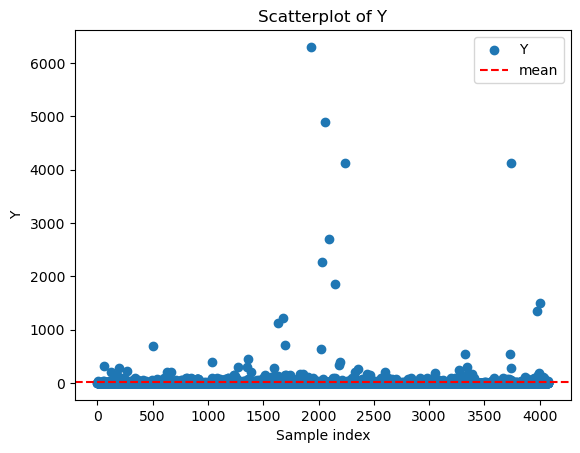

MSE Scores: 0    146.463673
1    112.242840
2     94.854210
3    312.891138
4     28.088259
5    276.131894
6     19.887307
7    205.140799
8    205.735985
9     47.218395
Name: RMSE, dtype: float64
Mean MSE: 144.86544997652857


In [83]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics.loc[len(reg_metrics)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='DUMMY','RMSE'])}")

We can see that the dummy classifier doesn't do much, as with few outliers, but that generates much leverage, the MSE is indeed very high

## Single decision tree

In [84]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics.loc[len(reg_metrics)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='TREE','RMSE'])}")

MSE Scores: 10    337.465237
11    104.001138
12    252.860689
13     82.084010
14    293.462879
15     54.801520
16    205.452500
17    132.182403
18    320.267162
19    295.294390
Name: RMSE, dtype: float64
Mean MSE: 207.78719301611827


## RandomForest

In [85]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics.loc[len(reg_metrics)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='RF','RMSE'])}")

MSE Scores: 20    136.786037
21    138.425245
22    120.646226
23    306.488084
24     60.200116
25    314.353093
26     49.089314
27    161.674252
28    128.043877
29    233.567285
Name: RMSE, dtype: float64
Mean MSE: 164.92735277453082


## SVM

In [86]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics.loc[len(reg_metrics)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='SVM','RMSE'])}")

MSE Scores: 30    140.731329
31    312.728037
32     70.882227
33     99.321912
34     73.786322
35    226.642903
36     39.331745
37    233.662694
38     45.388247
39    243.196259
Name: RMSE, dtype: float64
Mean MSE: 148.5671673993857


## kNearestNeighbor

In [87]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics.loc[len(reg_metrics)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics.loc[len(reg_metrics)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics.loc[reg_metrics['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics.loc[reg_metrics['Model']=='KNN','RMSE'])}")

MSE Scores: 40     84.548059
41     69.120519
42     84.402678
43     84.429399
44    104.825672
45    324.568586
46    243.943248
47    131.553009
48    153.306661
49    288.615141
Name: RMSE, dtype: float64
Mean MSE: 156.93129717431708


## Some plots

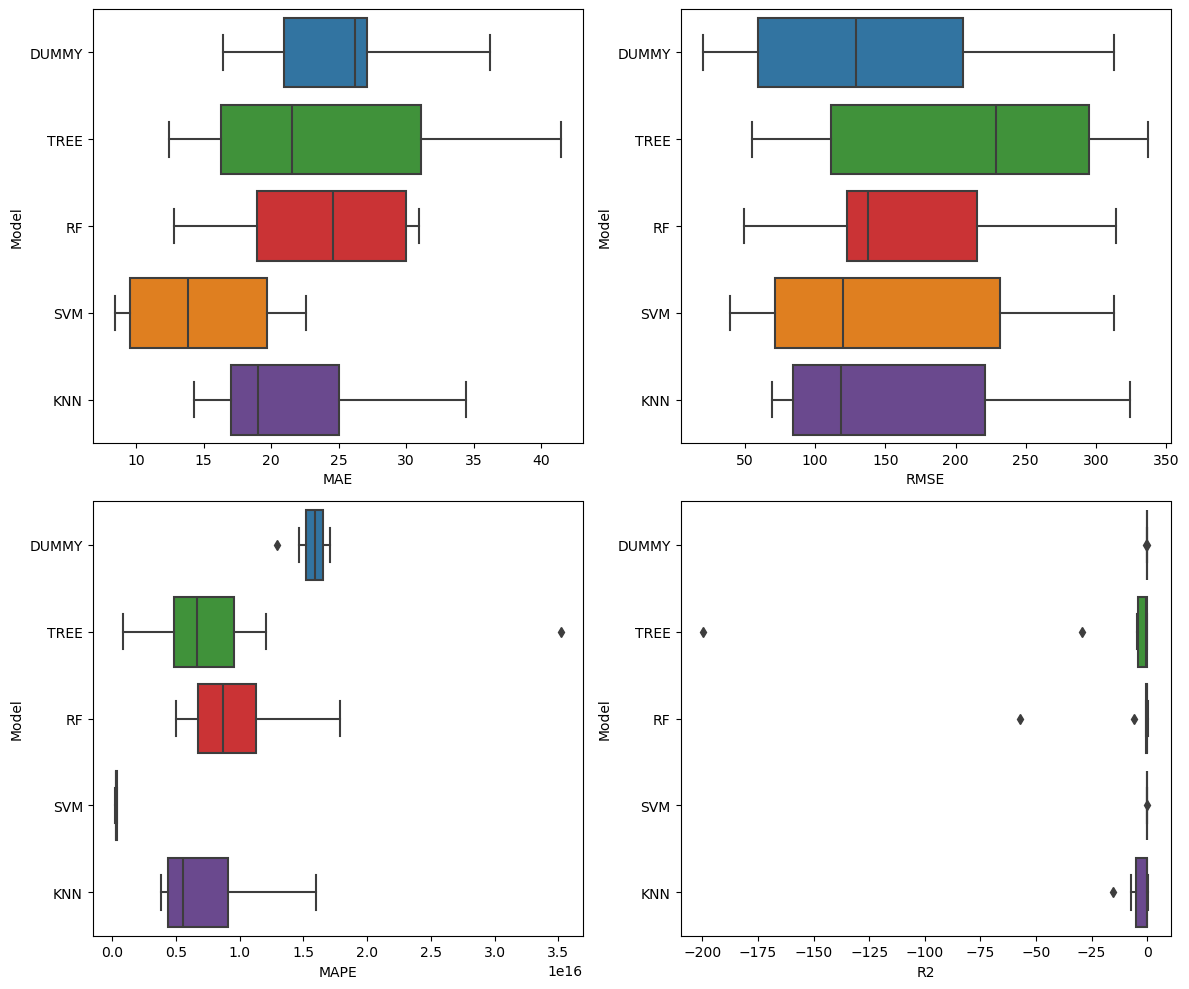

In [88]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

## Use only multimedial data

In [89]:
X.info()
X.drop(columns=['pictures', 'videos', 'gifs'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   quotes               4078 non-null   float64
 1   is.retweet           4078 non-null   float64
 2   external.link        4078 non-null   float64
 3   pictures             4078 non-null   float64
 4   videos               4078 non-null   float64
 5   gifs                 4078 non-null   float64
 6   multimedial_content  4078 non-null   float64
 7   user.image           4078 non-null   float64
 8   user.bio             4078 non-null   float64
 9   user.website         4078 non-null   float64
 10  user.tweets          4078 non-null   float64
 11  user.following       4078 non-null   float64
 12  user.media           4078 non-null   float64
 13  n_hashtags           4078 non-null   float64
dtypes: float64(14)
memory usage: 446.2 KB


In [90]:
reg_metrics_new = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

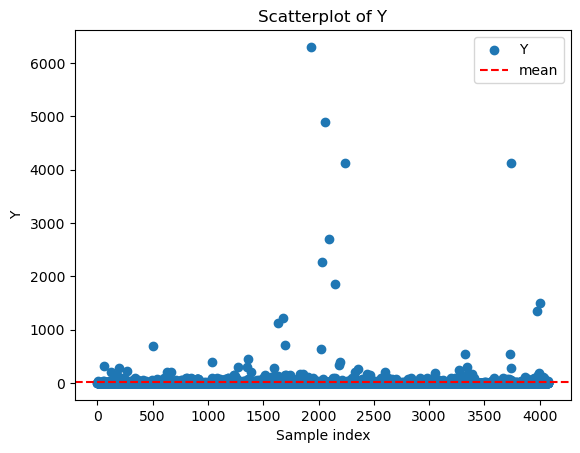

MSE Scores: 0     42.134493
1     65.659787
2     22.222854
3     39.120624
4    234.053984
5     31.324739
6    210.362909
7     99.443989
8    431.745319
9     34.145202
Name: RMSE, dtype: float64
Mean MSE: 121.0213900241938


In [91]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='DUMMY','RMSE'])}")

In [92]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='TREE','RMSE'])}")

MSE Scores: 10    223.129706
11    364.105339
12     95.188017
13    178.752773
14    244.607609
15    232.918866
16    441.129650
17    207.464482
18    187.104284
19    148.442388
Name: RMSE, dtype: float64
Mean MSE: 232.2843112955415


In [93]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor()
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='RF','RMSE'])}")

MSE Scores: 20    222.027571
21     93.249378
22    119.494502
23    251.063264
24    327.937870
25     65.754725
26     60.865955
27    128.567729
28    153.085804
29    208.450389
Name: RMSE, dtype: float64
Mean MSE: 163.04971868610414


In [94]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='SVM','RMSE'])}")

MSE Scores: 30     71.812343
31    262.086349
32     40.871137
33     32.943279
34     24.639626
35    208.957299
36    191.452294
37     18.990472
38    378.715484
39     74.184693
Name: RMSE, dtype: float64
Mean MSE: 130.46529759351174


In [95]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics_new.loc[len(reg_metrics_new)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_new.loc[reg_metrics_new['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_new.loc[reg_metrics_new['Model']=='KNN','RMSE'])}")

MSE Scores: 40    169.400494
41     86.405729
42    351.291348
43     66.903272
44    228.812059
45    236.694469
46     31.277520
47     73.339729
48    223.999230
49     60.527574
Name: RMSE, dtype: float64
Mean MSE: 152.8651423359065


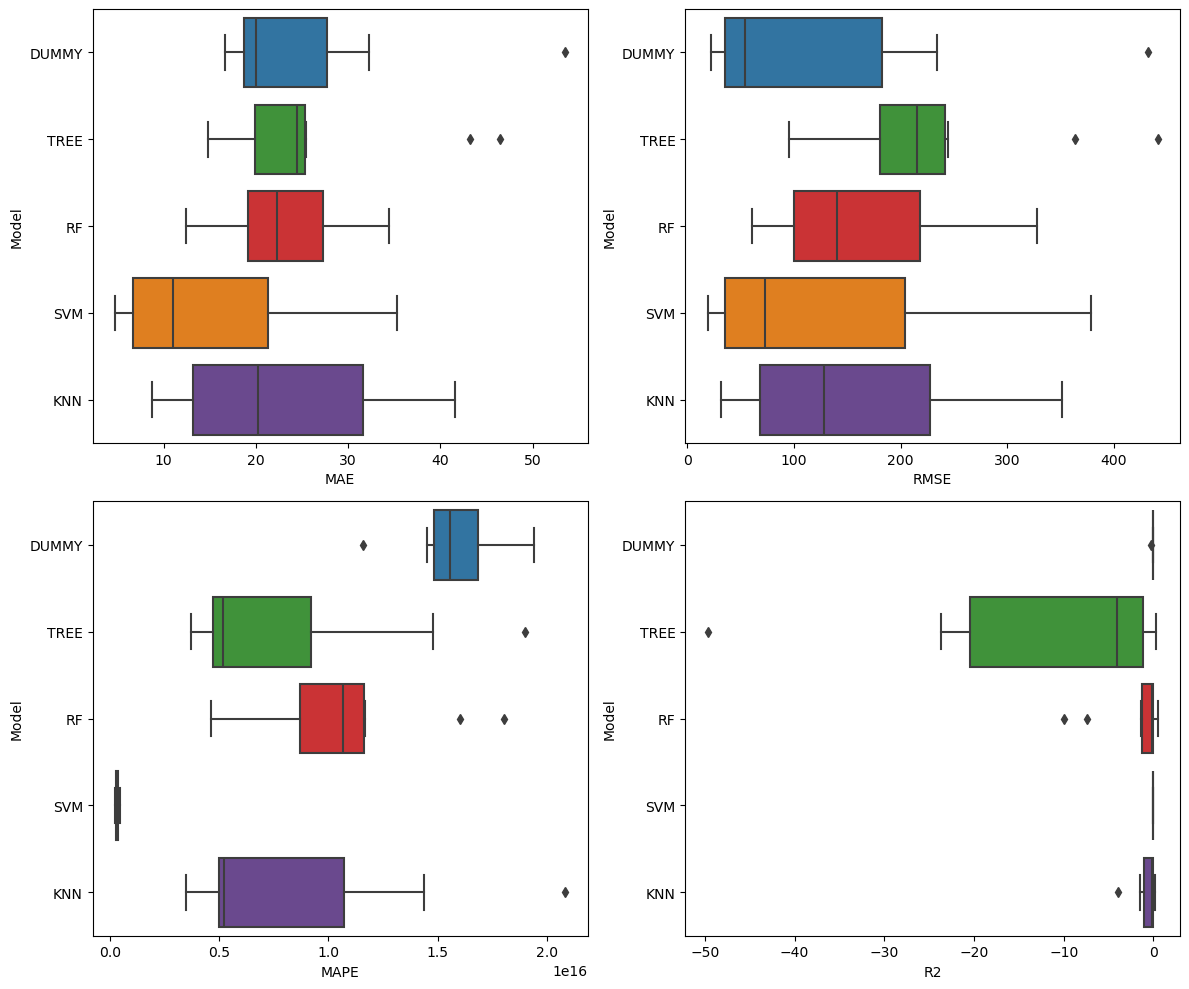

In [96]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics_new, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_new, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

## Add vectorized text

In [97]:
X = merged_df
X.drop(columns=['processed text'], inplace=True)
X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Columns: 1014 entries, 0 to 1013
dtypes: float64(1014)
memory usage: 31.5 MB


In [98]:
reg_metrics_text = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'R2'])

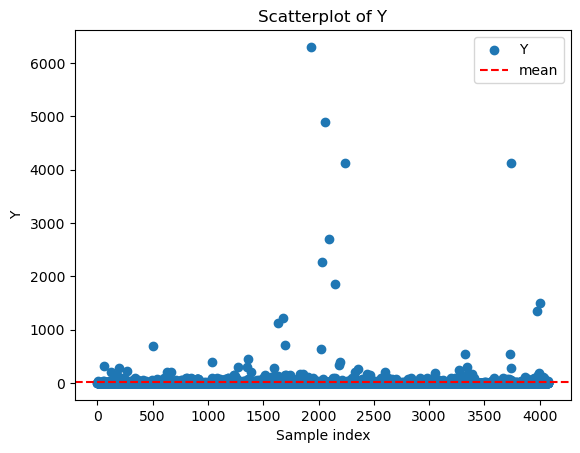

MSE Scores: 0     35.692518
1    284.711914
2     97.096637
3     30.190329
4     27.882969
5    208.852780
6     34.650056
7    380.016795
8     94.490960
9    116.145486
Name: RMSE, dtype: float64
Mean MSE: 130.9730443194439


In [99]:
dummy_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in dummy_kfolds.split(X):
    dummy_regressor = DummyRegressor()
    dummy_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_dummy_reg = dummy_regressor.predict(X.iloc[test_idx])
    current_dummy_mae = mean_absolute_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_mse = mean_squared_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_rmse = np.sqrt(current_dummy_mse)
    current_dummy_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_dummy_reg)
    current_dummy_r2 = r2_score(Y.iloc[test_idx], y_dummy_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', current_dummy_mae, current_dummy_rmse, current_dummy_mape, current_dummy_r2]

# Dovrebbe essere lo stesso di fare:
# lin_regressor = LinearRegression()
# Y_reshaped = Y.values.reshape(-1, 1)

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, np.ones_like(Y_reshaped), Y_reshaped, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]


#Scatterplot of Y
mean_y = np.mean(Y)
plt.scatter(np.arange(len(Y)), Y, label='Y')
plt.axhline(y=mean_y, color='r', linestyle='--', label='mean')    # Plot the mean
plt.title('Scatterplot of Y')
plt.xlabel('Sample index')
plt.ylabel('Y')
plt.legend()
plt.show()

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='DUMMY','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='DUMMY','RMSE'])}")

In [100]:
# Decision Tree Regressor
# Initialize a decision tree regressor instance
tree_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in tree_kfolds.split(X):
    tree_regressor = DecisionTreeRegressor()
    tree_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_tree_reg = tree_regressor.predict(X.iloc[test_idx])
    current_tree_mae = mean_absolute_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_mse = mean_squared_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_rmse = np.sqrt(current_tree_mse)
    current_tree_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_tree_reg)
    current_tree_r2 = r2_score(Y.iloc[test_idx], y_tree_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['TREE', current_tree_mae, current_tree_rmse, current_tree_mape, current_tree_r2]

# Dovrebbe essere lo stesso di fare:
# rf = RandomForestRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(rd, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(rf, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='TREE','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='TREE','RMSE'])}")

MSE Scores: 10    373.745829
11     74.384611
12    225.573220
13    401.885541
14    327.559404
15     87.195462
16     66.994464
17    285.239286
18    384.302445
19    217.163924
Name: RMSE, dtype: float64
Mean MSE: 244.40441842763857


In [101]:
# Random Forest Regressor
# Initialize a random forest regressor instance
rf_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in rf_kfolds.split(X):
    rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=100, random_state=42)
    rf_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_rf_reg = rf_regressor.predict(X.iloc[test_idx])
    current_rf_mae = mean_absolute_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_mse = mean_squared_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_rmse = np.sqrt(current_rf_mse)
    current_rf_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_rf_reg)
    current_rf_r2 = r2_score(Y.iloc[test_idx], y_rf_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['RF', current_rf_mae, current_rf_rmse, current_rf_mape, current_rf_r2]
     
# Dovrebbe essere lo stesso di fare:
# dummy_regressor = DummyRegressor()

# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(lin_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(lin_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='RF','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='RF','RMSE'])}")

### TODO: STANDARDIZE THE COVARIATES FOR SVM!!!

In [ ]:
sv_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in sv_kfolds.split(X):
    sv_regressor = SVR()
    sv_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_sv_reg = sv_regressor.predict(X.iloc[test_idx])
    current_sv_mae = mean_absolute_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_mse = mean_squared_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_rmse = np.sqrt(current_sv_mse)
    current_sv_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_sv_reg)
    current_sv_r2 = r2_score(Y.iloc[test_idx], y_sv_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['SVM', current_sv_mae, current_sv_rmse, current_sv_mape, current_sv_r2]

# Dovrebbe essere lo stesso di fare:
# sv_regressor = SVR()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(sv_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(sv_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_text.loc[len(reg_metrics_text)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='SVM','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='SVM','RMSE'])}")

MSE Scores: 30     43.975267
31     70.042117
32     23.348494
33    290.036799
34    313.014244
35    183.879675
36    243.845542
37     21.846456
38     39.860545
39    148.783642
Name: RMSE, dtype: float64
Mean MSE: 137.86327811162028


In [ ]:
knn_kfolds = KFold(n_splits=10, shuffle=True)
for train_idx, test_idx in knn_kfolds.split(X):
    knn_regressor = KNeighborsRegressor()
    knn_regressor.fit(X.iloc[train_idx], Y.iloc[train_idx])
    y_knn_reg = knn_regressor.predict(X.iloc[test_idx])
    current_knn_mae = mean_absolute_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_mse = mean_squared_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_rmse = np.sqrt(current_knn_mse)
    current_knn_mape = mean_absolute_percentage_error(Y.iloc[test_idx], y_knn_reg)
    current_knn_r2 = r2_score(Y.iloc[test_idx], y_knn_reg)
    reg_metrics_text.loc[len(reg_metrics_text)] = ['KNN', current_knn_mae, current_knn_rmse, current_knn_mape, current_knn_r2]

# Dovrebbe essere lo stesso di fare:
# knn_regressor = KNeighborsRegressor()
#
# Perform cross-validation to get MSE scores
# mse_scores = -cross_val_score(knn_regressor, X, Y,
#                              scoring='neg_mean_squared_error', cv=10)
# mae scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_error', cv=10)
# mape_scores = -cross_val_score(knn_regressor, X, Y, scoring='neg_mean_absolute_percentage_error', cv=10)
# reg_metrics_new.loc[len(reg_metrics_new)] = ['DUMMY', mae_scores, mse_scores, mape_scores]

# Print MSE scores and mean MSE
print(f"MSE Scores: {reg_metrics_text.loc[reg_metrics_text['Model']=='KNN','RMSE']}")
print(f"Mean MSE: {np.mean(reg_metrics_text.loc[reg_metrics_text['Model']=='KNN','RMSE'])}")

MSE Scores: 40     80.693395
41     73.572770
42    336.513443
43    102.639923
44    110.476793
45    282.638372
46    339.228744
47     55.148491
48    116.305752
49    133.747305
Name: RMSE, dtype: float64
Mean MSE: 163.0964987134884


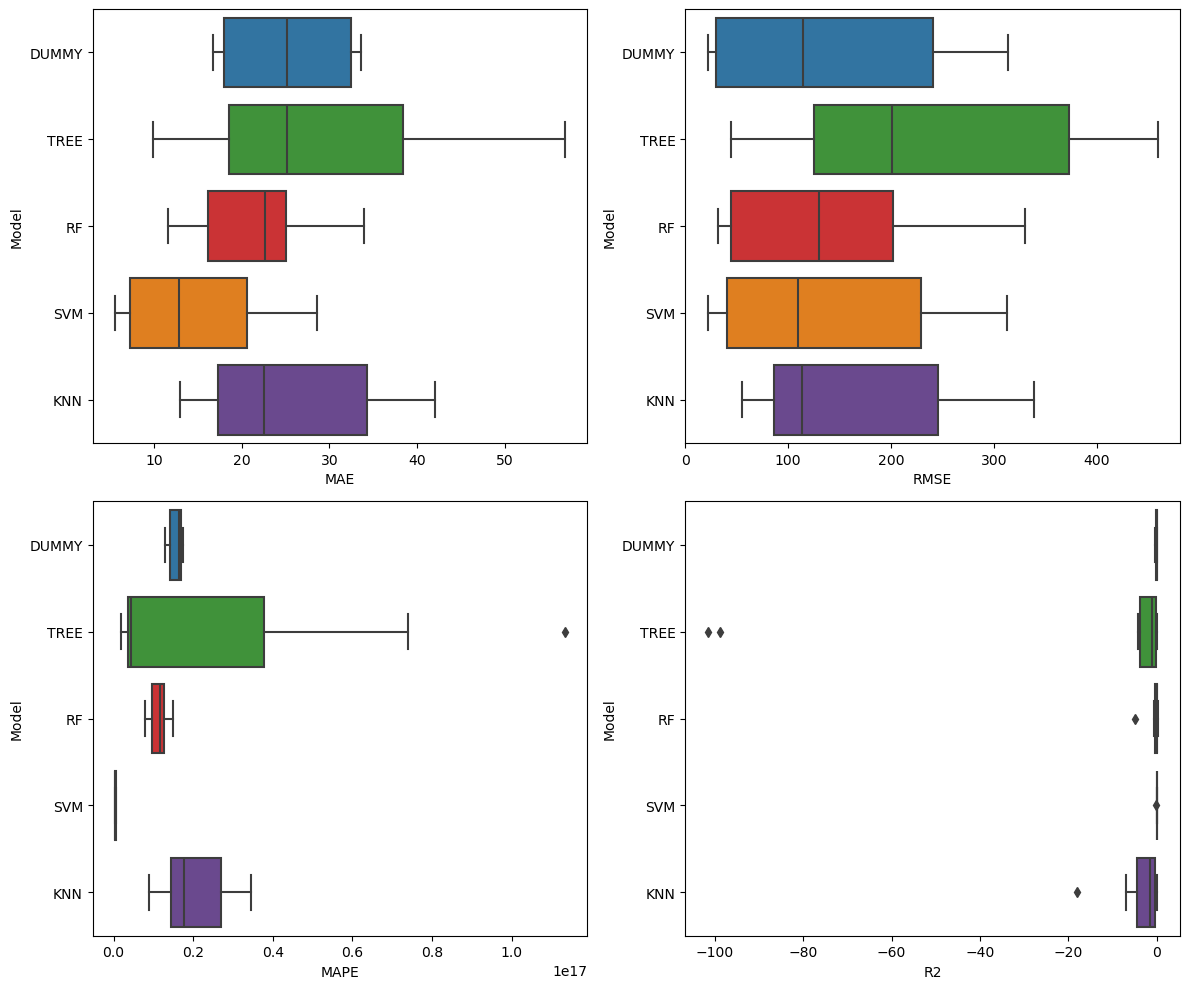

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics_text, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics_text, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])


plt.tight_layout()
plt.show()

### Compare the three models

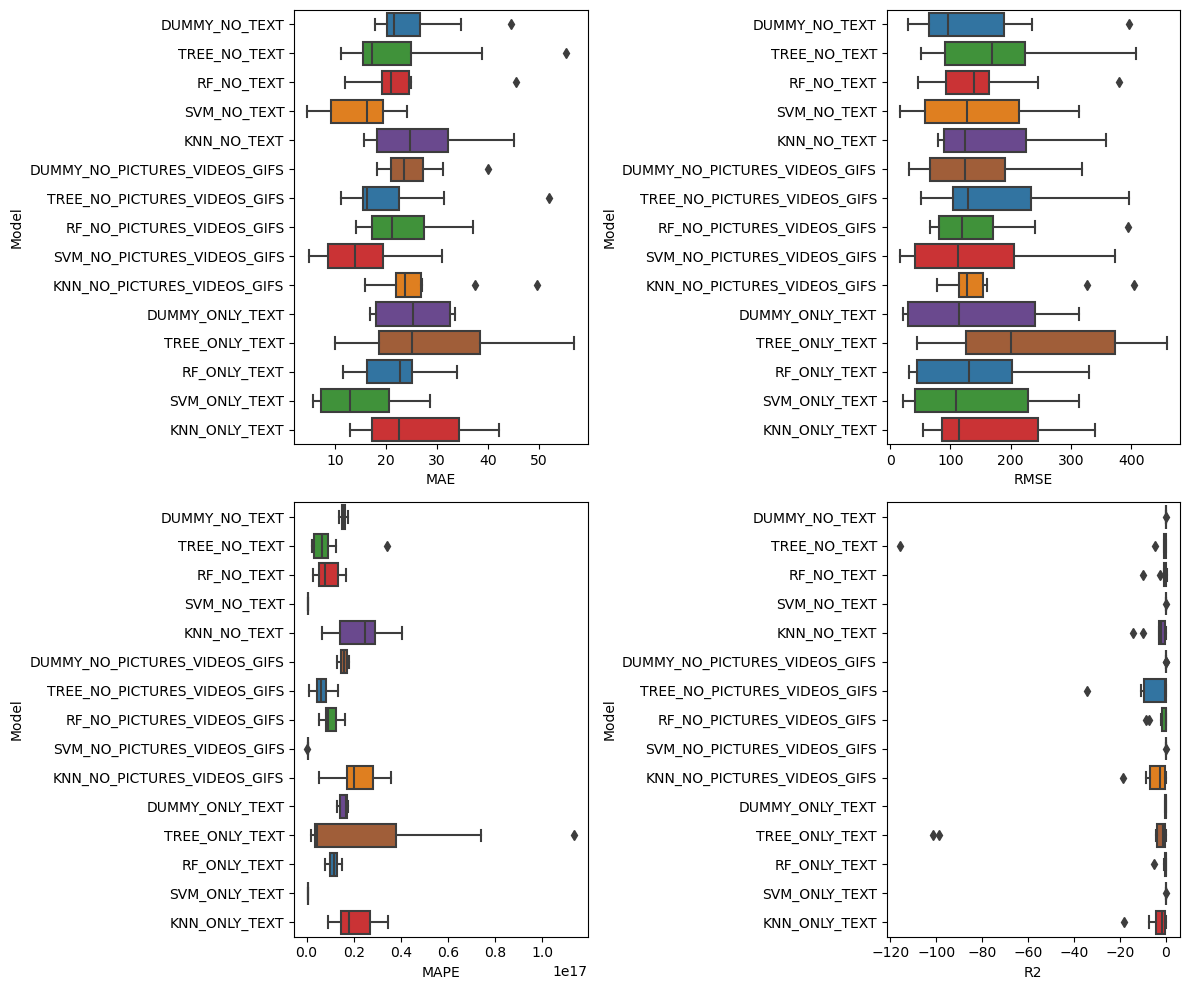

In [ ]:
# Compare the results of the models with or without text features
reg_metrics['Model'] = reg_metrics['Model'] + '_NO_TEXT'
reg_metrics_new['Model'] = reg_metrics_new['Model'] + '_NO_PICTURES_VIDEOS_GIFS'
reg_metrics_text['Model'] = reg_metrics_text['Model'] + '_ONLY_TEXT'
reg_metrics = pd.concat([reg_metrics, reg_metrics_new, reg_metrics_text])
reg_metrics.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(data=reg_metrics, x="MAE", y="Model", ax=axs[0, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="RMSE", y="Model", ax=axs[0, 1], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="MAPE", y="Model", ax=axs[1, 0], palette=sns.color_palette('Paired')[1::2])
sns.boxplot(data=reg_metrics, x="R2", y="Model", ax=axs[1, 1], palette=sns.color_palette('Paired')[1::2])

plt.tight_layout()
plt.show()